In [7]:
from pathlib import Path
import os
import torch
import time
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import datetime
import matplotlib.pyplot as plt
import copy
# Téléchargement des données

from datamaestro import prepare_dataset
ds = prepare_dataset("com.lecun.mnist");


train_images, train_labels = ds.train.images.data(), ds.train.labels.data()
test_images, test_labels =  ds.test.images.data(), ds.test.labels.data()

# Tensorboard : rappel, lancer dans une console tensorboard --logdir runs
#writer = SummaryWriter("runs/runs"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Pour visualiser
# Les images doivent etre en format Channel (3) x Hauteur x Largeur
images = torch.tensor(train_images[0:8]).unsqueeze(1).repeat(1,3,1,1).double()/255.
# Permet de fabriquer une grille d'images
images = make_grid(images)
# Affichage avec tensorboard
#writer.add_image(f'samples', images, 0)

savepath = Path("model.pch")

<ipython-input-7-9855dbe6a70c>:28: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  images = torch.tensor(train_images[0:8]).unsqueeze(1).repeat(1,3,1,1).double()/255.


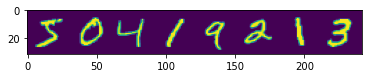

In [2]:
plt.imshow(images[0])

# Dataset + Dataloader

In [8]:
class MonDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data.reshape((data.shape[0], data.shape[1]*data.shape[2])), dtype=torch.float)
        self.target = torch.tensor(target, dtype=torch.float)

    def __getitem__(self, index):
        return (self.data[index], self.target[index])

    def __len__(self):
        return len(self.data)

In [9]:
def addNoiseSP(img, proba=0.1, minv=0, maxv=255):
    
    nbLin, nbCol = img.shape
    
    #compute number of pixel to change
    nbChange = int(nbLin*nbCol*proba)
    
    #create the noise to put in the image
    tmp = np.concatenate((np.full(nbLin*nbCol-nbChange, -1), np.full(nbChange//2, minv),  np.full(nbChange-(nbChange//2), maxv)), axis=None)
    np.random.shuffle(tmp)
    tmp = tmp.reshape(img.shape)
    
    return np.where(tmp==-1, img, tmp)#Put the s&p noise in the img

In [5]:
class imageBruitee(Dataset):
    
    def __init__(self, data, noiseProba):
        self.target = torch.tensor(data.reshape((data.shape[0], data.shape[1]*data.shape[2])), dtype=torch.float)
        imgNoise = np.array([addNoiseSP(img, noiseProba) for img in data])
        self.data = torch.tensor(imgNoise.reshape((imgNoise.shape[0], imgNoise.shape[1]*imgNoise.shape[2])), dtype=torch.float)

    def __getitem__(self, index):
        return (self.data[index], self.target[index])

    def __len__(self):
        return len(self.data)

In [10]:
BATCH_SIZE = 100    
train_loader = DataLoader(MonDataset(train_images, train_labels), shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(MonDataset(test_images, test_labels), shuffle=True, batch_size=BATCH_SIZE)

# Autoencoder (with HighWay version)

In [19]:
class AutoEncoder(nn.Module):
    
    def __init__(self, activation, layers):
        super().__init__()
        self.act = activation()
        self.layers = []
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1], bias=True))

        
    def encoder(self, x):
        for layer in self.layers:
            x = layer(x)
            x = self.act(x)
        return x

    
    def decoder(self, x):
        for layer in reversed(self.layers):
            x = self.act(F.linear(x, layer.weight.t()))
        return x

    
    def forward(self, x):
        encoded_feats = self.encoder(x)
        reconstructed_output = self.decoder(encoded_feats)
        return  reconstructed_output
    
    
    def parameters(self):
        parameters = []
        for layer in self.layers:
            parameters.extend(layer.parameters())
        return parameters

In [17]:
class higwayModule(nn.Module):
    
    def __init__(self, inputDim, outputDim, activation=nn.ReLU,bias=True):
        super().__init__()
        
        # Transform gate
        self.linear1 = nn.Linear(inputDim, outputDim, bias=True)
        self.sigmoid = nn.Sigmoid()
        
        # Normal layer
        self.linear2 = nn.Linear(inputDim, outputDim, bias)
        self.act = activation()
    
    def forward(self, x):
        
        T = self.sigmoid(self.linear1(x))
        C = 1.0 - T
        H = self.act(self.linear2(x))
        
        return T*H+upSubSampling(x, T.shape[1])*C

    
def higwayFonction(x, W, W_t, activation=F.relu):
    T = torch.sigmoid(F.linear(x, W_t.t()))
    C = 1.0 - T
    H = activation(F.linear(x, W.t()))

    return T*H+upSubSampling(x, T.shape[1])*C


def upSubSampling(t, outDim):
    return subSampling(t, outDim) if outDim<=t.shape[1] else upSampling(t, outDim)
    

def subSampling(t, outDim):
    res = t[:, 0::t.shape[1]//outDim]
    return res[:, :outDim]


def upSampling(t, outDim):
    coefMul = int(np.ceil(outDim/t.shape[1]))
    return t.repeat_interleave(coefMul,1)[:, :outDim]
    

class HighWayAutoEncoder(nn.Module):
    

    def __init__(self, activation, layers):
        super().__init__()
        self.act = activation()
        self.layers = []
        for i in range(len(layers)-1):
            self.layers.append(higwayModule(layers[i], layers[i+1], activation=activation, bias=True))
      
            
    def encoder(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
            
    
    def decoder(self, x):
        for layer in reversed(self.layers):
            x = higwayFonction(x, layer.linear1.weight, layer.linear2.weight)
        return x

    
    def forward(self, x):
        encoded_feats = self.encoder(x)
        reconstructed_output = self.decoder(encoded_feats)

        return  reconstructed_output
    
    
    def parameters(self):
        parameters = []
        for layer in self.layers:
            parameters.extend(layer.parameters())
        return parameters

# Training

In [18]:
#writer = SummaryWriter()

# Autoencodeur
n1 = 28*28
n2 = 196
n3 = 49
n4 = 7
epsilon = 1e-3
num_epochs = 50

model_2 = HighWayAutoEncoder(nn.ReLU, [784,49, 49])
model_3 = AutoEncoder(nn.ReLU, [n1,n2,n3,n4])

model = model_3 # choose model

optimizer = torch.optim.Adam(params=model.parameters(),lr=epsilon)
optimizer.zero_grad()

error = torch.nn.MSELoss()

# Training loop
print("Training ...")

train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        outputs = model(images)
        train_loss = error(outputs, images)
        
        train_loss.backward()
        optimizer.step()
        
        #writer.add_scalar('Loss/train', train_loss, epoch)

    model.eval()
    for i, (images, labels) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(images)
        test_loss = error(outputs, images)
        
        #writer.add_scalar('Loss/test', test_loss, epoch)
  #if(epoch%10==0):
    print(f"Itérations {epoch}: train loss {train_loss}, test loss {test_loss}")
    train_loss_list.append(train_loss); test_loss_list.append(test_loss)
        
writer.close()

Training ...
<class 'torch.Tensor'>
torch.Size([100, 7])


ZeroDivisionError: division by zero

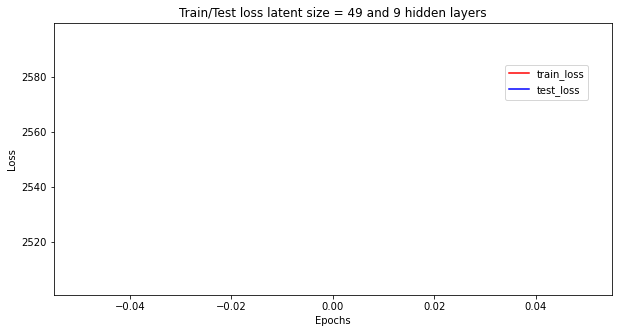

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

x = np.arange(len(train_loss_list))

a, = ax.plot(x, train_loss_list,color="red", label="train_loss")
b, = ax.plot(x, test_loss_list,color="blue", label="test_loss")
ax.set(xlabel='Epochs',ylabel='Loss')
ax.set_title(f"Train/Test loss latent size = 49 and 9 hidden layers")

plt.figlegend((a,b),("train_loss","test_loss"), loc=(0.8, 0.7))

# Results

## Data reconstruction

<ipython-input-27-088f35fb9e38>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images2 = torch.tensor(out.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.


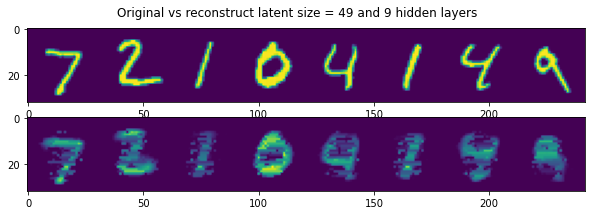

In [27]:
nb1,nb2 = 0,8
TEST = True
with torch.no_grad():
    if TEST == True:
        data = test_images  
    else:
        data = train_images
    out = model(torch.tensor(data[nb1:nb2], dtype=torch.float).reshape(nb2-nb1,784))
  
    images1 = torch.tensor(data[nb1:nb2]).unsqueeze(1).repeat(1,3,1,1).double()/255.
    images2 = torch.tensor(out.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.
    # Permet de fabriquer une grille d'images
    images1 = make_grid(images1)
    images2 = make_grid(images2)
    
    #writer.add_image(f'samples', images1, 0)
    #writer.add_image(f'reconstruc', images2, 0)
    
    i=0
    fig, axs = plt.subplots(2,figsize=(10,3))
    fig.suptitle('Original vs reconstruct latent size = 49 and 9 hidden layers')
    axs[0].imshow(images1[i])
    axs[1].imshow(images2[i])

## Data generation

<ipython-input-17-c0f61a8d4f85>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images2 = torch.tensor(decode_features_1.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.
<ipython-input-17-c0f61a8d4f85>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images3 = torch.tensor(decode_features_2.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.


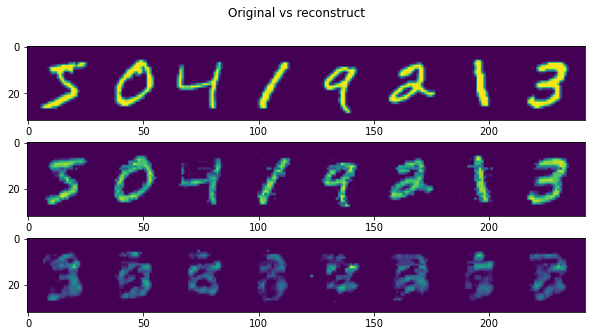

In [17]:
with torch.no_grad():
    nb1,nb2 = 0,8
  
    out = model(torch.tensor(train_images[nb1:nb2], dtype=torch.float).reshape(nb2-nb1,784))
    encode_features = model.encoder(torch.tensor(train_images[nb1:nb2], dtype=torch.float).reshape(nb2-nb1,784))
    encode_features_1 = encode_features + torch.rand(encode_features.size(0), encode_features.size(1))
    encode_features_2 = encode_features + 1000*torch.rand(encode_features.size(0), encode_features.size(1))
    decode_features_1 = model.decoder(encode_features_1)
    decode_features_2 = model.decoder(encode_features_2)

    images1 = torch.tensor(train_images[nb1:nb2]).unsqueeze(1).repeat(1,3,1,1).double()/255.
    images2 = torch.tensor(decode_features_1.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.
    images3 = torch.tensor(decode_features_2.reshape(nb2-nb1,28,28)).unsqueeze(1).repeat(1,3,1,1).double()/255.
    # Permet de fabriquer une grille d'images
    images1 = make_grid(images1)
    images2 = make_grid(images2)
    images3 = make_grid(images3)
    #writer.add_image(f'samples', images1, 0)
    #writer.add_image(f'reconstruc', images2, 0)
    
    i=0
    fig, axs = plt.subplots(3,figsize=(10,5))
    fig.suptitle('Original vs reconstruct')
    axs[0].imshow(images1[i])
    axs[1].imshow(images2[i])
    axs[2].imshow(images3[i])